<a href="https://colab.research.google.com/github/lo-uis/Team_ChoLab/blob/develop/stl_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab.drive
google.colab.drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
#!pip install pytorch-lightning

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# **前処理**

In [0]:
# tranform tensor
#前処理できる
#trainデータセットの前処理


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.RandomHorizontalFlip(), 
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #https://teratail.com/questions/234027
    
    ])

In [0]:
#validationデータセットの前処理
transform_val = transforms.Compose([
    transforms.RandomResizedCrop(64), #サイズ合わせ
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) ) #多分正規化
    ])

In [5]:
#load train
#学習に用いて良い画像は、STL10のtrain,unlabeled画像のみとする。
#STL10のテスト画像は、上記の運営賞に用いるので、validationとして用いること
train = torchvision.datasets.STL10(
    root=".", 
    split='train', 
    folds=None,                          #０〜９で選べるぽい
    transform=transform_train,                     #読み込み時の処理
    target_transform=None, 
    download=True)

Extracting ./stl10_binary.tar.gz to .


In [6]:
#load test for validation
val = torchvision.datasets.STL10(
    root=".", 
    split="test", 
    folds=None,                          
    transform=transform_val,                     
    target_transform=None, 
    download=True)

Files already downloaded and verified


In [0]:
#train[0][0].shape

In [0]:
#可視化してみる
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[1][0],(1,2,0))
img.shape

torch.Size([96, 96, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


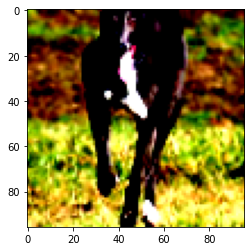

In [0]:
plt.imshow(img)

In [0]:
#type(train[0])

In [0]:
#train[0][0]

In [0]:
#train[1][1]

In [0]:
batch_size = 32

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False) # testはvaldationとして扱う

classes = ("airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck")

#dataloaders_dict = {"train": train_dataloader, "val": val_dataloader} # 辞書オブジェクトにまとめる

In [0]:
import numpy as np

def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [0]:
(data, target) = iter(training_loader).next()
mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha=1.0, use_cuda=torch.cuda.is_available())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


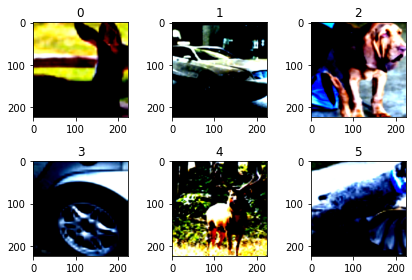

# **VGG16ファインチューニング**
参考：https://github.com/YutaroOgawa/pytorch_advanced

In [0]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.vgg16(pretrained=use_pretrained).to(device)
print(model)


model.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [0]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 再学習するパラメーターを指定する
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [0]:
epochs = 60
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in training_loader:
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)

epoch * 1
training loss: 0.0216, training acc 0.7702
validation loss: 0.0116, validation acc0.8750
Validation loss decreased (inf --> 0.011639).  Saving model ...
epoch * 2
training loss: 0.0126, training acc 0.8562
validation loss: 0.0115, validation acc0.8704
Validation loss decreased (0.011639 --> 0.011511).  Saving model ...
epoch * 3
training loss: 0.0120, training acc 0.8614
validation loss: 0.0111, validation acc0.8734
Validation loss decreased (0.011511 --> 0.011147).  Saving model ...
epoch * 4
training loss: 0.0112, training acc 0.8754
validation loss: 0.0104, validation acc0.8819
Validation loss decreased (0.011147 --> 0.010386).  Saving model ...
epoch * 5
training loss: 0.0104, training acc 0.8824
validation loss: 0.0105, validation acc0.8780
EarlyStopping counter: 1 out of 3
epoch * 6
training loss: 0.0104, training acc 0.8838
validation loss: 0.0098, validation acc0.8886
Validation loss decreased (0.010386 --> 0.009821).  Saving model ...
epoch * 7
training loss: 0.0095,

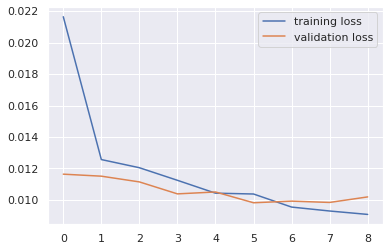

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

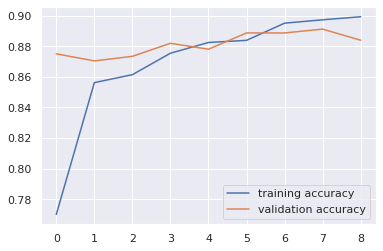

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

**混同行列**
参考：https://github.com/takoroy/mypytorch-memo

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, labels):
    import seaborn as sns
    import pandas as pd
    sns.set()
    
    df = pd.DataFrame(cm)
    df.index = labels
    df.columns = labels

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df, annot=True, fmt="d", linewidths=.5, ax=ax)

def validation_confusion_matrix(model):
    images_so_far = 0
    fig = plt.figure()

    all_labels = np.array([])
    all_preds = np.array([])
    for i, data in enumerate(validation_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, labels.cpu().data.numpy())
        all_preds = np.append(all_preds, preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes)

<Figure size 432x288 with 0 Axes>

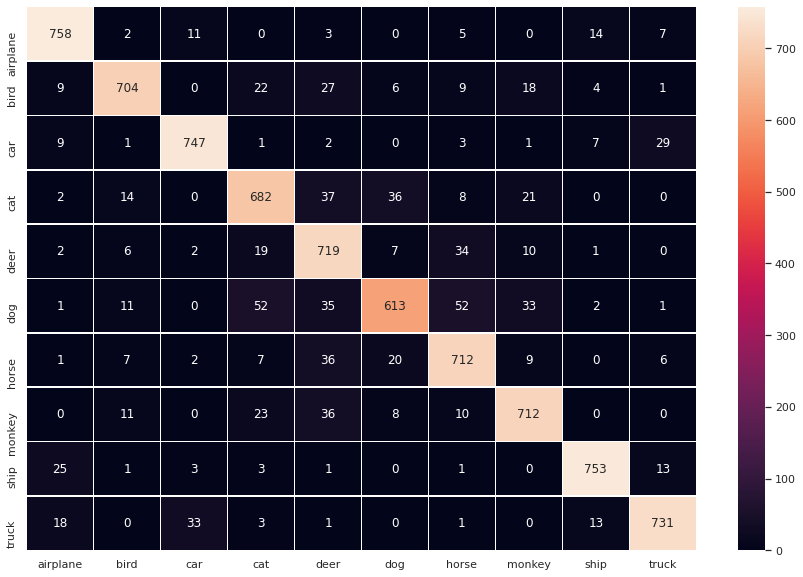

In [0]:
validation_confusion_matrix(model)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.mobilenet_v2(pretrained=use_pretrained).to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [0]:
print(model)

In [0]:
model.classifier[1] = nn.Linear(in_features=1280, out_features=10).to(device)
print(model)

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [0]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.1.weight", "classifier.1.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.1.weight
classifier.1.bias
-----------
[Parameter containing:
tensor([[-2.2497e-03,  2.2229e-02, -2.7649e-02,  ...,  1.5216e-02,
         -4.8866e-03,  2.7289e-02],
        [-1.1160e-02, -1.0208e-02, -2.5367e-02,  ...,  1.4590e-02,
         -2.5211e-02, -2.1567e-02],
        [-7.3483e-04,  2.7705e-02,  7.8432e-03,  ...,  1.8074e-03,
         -9.8257e-03, -2.0891e-02],
        ...,
        [-1.1987e-02,  2.1438e-02, -1.7968e-02,  ..., -2.6422e-02,
          1.6859e-02,  2.7601e-02],
        [-3.6512e-03,  5.8913e-03, -2.8255e-03,  ..., -1.5850e-02,
         -5.3521e-05, -6.1470e-03],
        [ 1.3076e-03, -1.8492e-02,  4.9345e-03,  ...,  2.1213e-02,
         -4.7793e-03, -8.1486e-03]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0062, -0.0256, -0.0179, -0.0077, -0.0205,  0.0066,  0.0088,  0.0013,
        -0.0223, -0.0120], device='cuda:0', requires_grad=True)]


In [0]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)

# **DenseNet**

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.densenet161(pretrained=use_pretrained).to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [12]:
model.classifier = nn.Linear(in_features=2208, out_features=10, bias=True).to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [14]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
#https://qiita.com/koshian2/items/4f91ac5cceb6125fd57e

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 再学習するパラメーターを指定する
update_param_names_1 = ["denseblock3"]
update_param_names_2 = ["denseblock4"]
update_param_names_3 = ["classifier.weight", "classifier.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
    
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif update_param_names_2[0] in name:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)
  

勾配計算なし。学習しない： features.conv0.weight
勾配計算なし。学習しない： features.norm0.weight
勾配計算なし。学習しない： features.norm0.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer1.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer1.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer2.norm2.bias
勾配計算なし。学習しない： features.denseblock1.denselayer2.conv2.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.weight
勾配計算なし。学習しない： features.denseblock1.denselayer3.norm1.bias
勾配計算なし。学習しない： features.denseblock1.denselayer3.conv1.weight
勾配計算

In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [17]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=3, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)

100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


epoch * 1
training loss: 0.0293, training acc 0.7518
validation loss: 0.0124, validation acc0.8914
Validation loss decreased (inf --> 0.012383).  Saving model ...


100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


epoch * 2
training loss: 0.0125, training acc 0.8760
validation loss: 0.0097, validation acc0.8998
Validation loss decreased (0.012383 --> 0.009736).  Saving model ...


100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


epoch * 3
training loss: 0.0103, training acc 0.8938
validation loss: 0.0087, validation acc0.9080
Validation loss decreased (0.009736 --> 0.008669).  Saving model ...


100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


epoch * 4
training loss: 0.0097, training acc 0.8988
validation loss: 0.0081, validation acc0.9170
Validation loss decreased (0.008669 --> 0.008091).  Saving model ...


100%|██████████| 250/250 [01:09<00:00,  3.59it/s]


epoch * 5
training loss: 0.0090, training acc 0.9086
validation loss: 0.0079, validation acc0.9185
Validation loss decreased (0.008091 --> 0.007853).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 6
training loss: 0.0087, training acc 0.9060
validation loss: 0.0078, validation acc0.9153
Validation loss decreased (0.007853 --> 0.007837).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 7
training loss: 0.0079, training acc 0.9178
validation loss: 0.0078, validation acc0.9176
Validation loss decreased (0.007837 --> 0.007768).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 8
training loss: 0.0077, training acc 0.9184
validation loss: 0.0079, validation acc0.9138
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 9
training loss: 0.0075, training acc 0.9190
validation loss: 0.0077, validation acc0.9160
Validation loss decreased (0.007768 --> 0.007678).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 10
training loss: 0.0068, training acc 0.9294
validation loss: 0.0071, validation acc0.9254
Validation loss decreased (0.007678 --> 0.007064).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 11
training loss: 0.0070, training acc 0.9222
validation loss: 0.0071, validation acc0.9240
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 12
training loss: 0.0063, training acc 0.9318
validation loss: 0.0071, validation acc0.9236
EarlyStopping counter: 2 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 13
training loss: 0.0064, training acc 0.9368
validation loss: 0.0067, validation acc0.9264
Validation loss decreased (0.007064 --> 0.006730).  Saving model ...


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 14
training loss: 0.0062, training acc 0.9348
validation loss: 0.0068, validation acc0.9229
EarlyStopping counter: 1 out of 3


  0%|          | 0/157 [00:00<?, ?it/s]

epoch * 15
training loss: 0.0062, training acc 0.9328
validation loss: 0.0070, validation acc0.9269
EarlyStopping counter: 2 out of 3


100%|██████████| 250/250 [01:09<00:00,  3.60it/s]


epoch * 16
training loss: 0.0059, training acc 0.9370
validation loss: 0.0068, validation acc0.9278
EarlyStopping counter: 3 out of 3
Early stopping


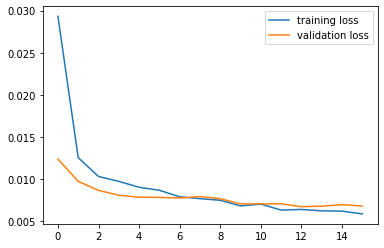

In [18]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

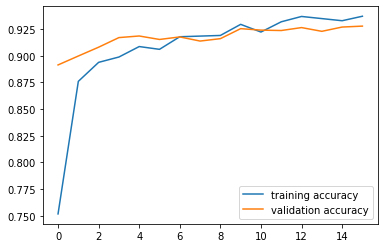

In [19]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [22]:
validation_confusion_matrix(model)

NameError: ignored

In [21]:
load_path = './weights.pth'
load_weights = torch.load(load_path)
model.load_state_dict(load_weights)

<All keys matched successfully>

In [22]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
model.cuda()

In [28]:
sample = train[12][0].unsqueeze(0)
sample.cuda()

tensor([[[[ 1.9749,  1.9749,  1.9920,  ...,  1.8893,  1.8893,  1.8893],
          [ 1.9749,  1.9749,  1.9920,  ...,  1.8893,  1.8893,  1.8893],
          [ 1.9578,  1.9578,  1.9749,  ...,  1.8893,  1.8893,  1.8893],
          ...,
          [ 0.6563,  0.6563,  0.6906,  ..., -0.1999,  0.3309,  0.4166],
          [ 0.5878,  0.6049,  0.6563,  ..., -0.2684,  0.2796,  0.3652],
          [ 0.5878,  0.6049,  0.6563,  ..., -0.2684,  0.2796,  0.3652]],

         [[ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9559,  1.9559],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9559,  1.9559],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9559,  1.9559],
          ...,
          [ 0.6954,  0.7129,  0.7479,  ...,  0.0301,  0.4503,  0.5203],
          [ 0.6429,  0.6604,  0.7129,  ..., -0.0224,  0.3978,  0.4678],
          [ 0.6429,  0.6604,  0.7129,  ..., -0.0224,  0.3978,  0.4678]],

         [[ 2.1694,  2.1694,  2.1868,  ...,  2.2914,  2.2740,  2.2740],
          [ 2.1694,  2.1694,  

In [30]:
y_predict = model.forward(sample)


RuntimeError: ignored

In [31]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [0]:
device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load("checkpoint.pt"))
model.to(device)

In [46]:
sample = train[0][0].unsqueeze(0)
sample.shape
print(type(sample))
sample = sample.cuda()
print(type(sample))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [47]:
y_predict = model.forward(sample)
y_predict

tensor([[-1.3234,  7.0989, -3.6721,  0.4300,  3.8496, -0.8465, -0.8806,  3.2290,
         -3.3804, -2.6938]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
model.eval()

In [50]:
y_predict.argmax()

tensor(1, device='cuda:0')

In [51]:
# 目標値
train[0][1]

1